<a href="https://colab.research.google.com/github/pavelpryadokhin/Testea/blob/master/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Проанализируем датасет, рассмотрим различные модели машинного обучения, и попробуем как можно точнее предсказать объём продаж

#Предобработка

In [ ]:
!pip install optuna
!pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor



In [ ]:
df = pd.read_excel('df.xlsx')
df.head()

,Unnamed: 0,Promo_start,Promo_end,Shipping_start,Shipping_end,Promo_type,Feat_2,Feat_3,Agent,Promo_id,Item_id,Feat_7,Promo_class,Feat_9,Feat_10,Feat_11,Feat_12,Target
0,0,2020-01-06,2020-01-12,2019-12-16,2020-01-15,L,8583.448739,33.335849,B,Promo №20.0,Item ID: 22.0,NaN,D,NaN,NaN,NaN,58379,4102
1,1,2020-01-06,2020-01-12,2019-12-16,2020-01-15,L,29944.602677,64.447170,B,Promo №19.0,Item ID: 62.0,NaN,D,NaN,NaN,NaN,73433,13311
2,2,2020-01-06,2020-01-12,2019-12-16,2020-01-15,L,5474.685269,64.447170,B,Promo №20.0,Item ID: 71.0,NaN,D,NaN,NaN,NaN,35067,1887
3,3,2020-01-06,2020-01-12,2019-12-16,2020-01-15,L,8583.448739,33.335849,B,Promo №20.0,Item ID: 31.0,NaN,D,NaN,NaN,NaN,36550,2346
4,4,2020-01-06,2020-01-12,2019-12-16,2020-01-15,L,6370.475595,51.994340,B,Promo №20.0,Item ID: 23.0,NaN,D,NaN,NaN,NaN,30909,4817


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14081 entries, 0 to 14080
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      14081 non-null  int64         
 1   Promo_start     14081 non-null  datetime64[ns]
 2   Promo_end       14081 non-null  datetime64[ns]
 3   Shipping_start  14081 non-null  datetime64[ns]
 4   Shipping_end    14081 non-null  datetime64[ns]
 5   Promo_type      14081 non-null  object        
 6   Feat_2          14081 non-null  float64       
 7   Feat_3          14081 non-null  float64       
 8   Agent           14081 non-null  object        
 9   Promo_id        14081 non-null  object        
 10  Item_id         14081 non-null  object        
 11  Feat_7          6668 non-null   float64       
 12  Promo_class     14081 non-null  object        
 13  Feat_9          5881 non-null   float64       
 14  Feat_10         6639 non-null   float64       
 15  Fe

In [ ]:
df['promo_duration'] = (df['Promo_end'] - df['Promo_start']).dt.days
df['shipping_duration'] = (df['Shipping_end'] - df['Shipping_start']).dt.days
df = df.drop(columns=['Promo_start', 'Promo_end', 'Shipping_start', 'Shipping_end','Unnamed: 0','Promo_id'])

for col in df.columns:
    print(col,df[col].isnull().sum())

Promo_type 0
Feat_2 0
Feat_3 0
Agent 0
Item_id 0
Feat_7 7413
Promo_class 0
Feat_9 8200
Feat_10 7442
Feat_11 7442
Feat_12 0
Target 0
promo_duration 0
shipping_duration 0


In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

train_df.head()

,Promo_type,Feat_2,Feat_3,Agent,Item_id,Feat_7,Promo_class,Feat_9,Feat_10,Feat_11,Feat_12,Target,promo_duration,shipping_duration
4436,L,74230.568223,27.088679,C,Item ID: 114.0,NaN,D,NaN,NaN,NaN,63672,318,13,20
10113,L,32828.976854,68.598113,A,Item ID: 63.0,NaN,D,NaN,NaN,NaN,82295,1593,24,1
7628,J,13912.694443,58.220755,C,Item ID: 74.0,12758.034045,D,2.490359e+07,1.393240e+06,18.871060,31866,581,6,32
8059,J,27316.420999,72.043396,C,Item ID: 82.0,25553.976314,D,2.598356e+07,2.180878e+06,15.467049,94019,542,6,26
9164,F,43505.136711,58.220755,C,Item ID: 85.0,60644.331112,D,9.938127e+07,9.470386e+06,22.558739,8272,1613,6,27


In [ ]:
# Определение категориальных и числовых признаков
cat_cols = ["Promo_type", "Agent", "Promo_class", 'Item_id']
num_cols = ["Feat_2", "Feat_3", "Feat_7", "Feat_9", "Feat_10", "Feat_11",
            "Feat_12", "promo_duration", "shipping_duration"]

# Пайплайн для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output = False,handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

imputer = IterativeImputer(
    max_iter=20,
    n_nearest_features=5,
    random_state=42
)

# Объединение с MICE
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("imputer", imputer)
])

# Применение к тренировочным данным
X_train = train_df.drop(columns=["Target"])
pipeline.fit(X_train)

# Трансформация тренировочных и тестовых данных
X_train_imputed = pipeline.transform(X_train)
X_test_imputed = pipeline.transform(test_df.drop(columns=["Target"]))


In [ ]:
# Получение названий колонок после преобразований
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Создание DataFrame
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=feature_names, index=X_train.index)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=feature_names, index=test_df.index)

# Проверка пропусков
print("Пропуски в трейне:", X_train_imputed_df.isnull().sum().sum())
print("Пропуски в тесте:", X_test_imputed_df.isnull().sum().sum())

Пропуски в трейне: 0
Пропуски в тесте: 0


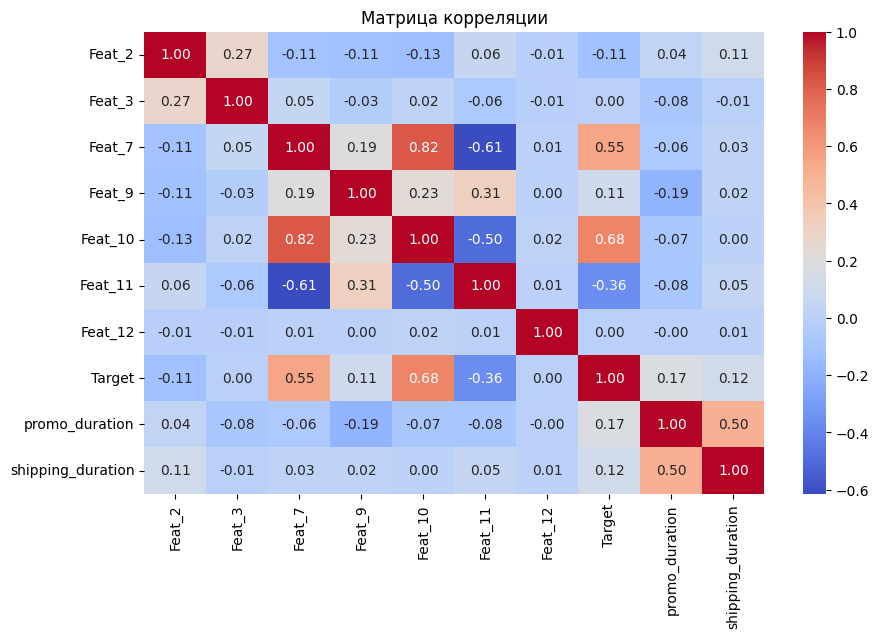

In [ ]:
df_corr = df.select_dtypes(include='number')
corr_matrix = df_corr .corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix , annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

In [ ]:
X_train_imputed_df["Target"] = train_df['Target']

df_corr = X_train_imputed_df.select_dtypes(include='number')
corr_matrix = df_corr.corr()
print(*sorted(corr_matrix["Target"],key=lambda x:abs(x)))

0.0003359014273296001 0.0005401166780180169 0.0021486910063219012 -0.0024697296172374013 -0.0027780460984981993 -0.002890362663809593 0.003679594361216873 0.004078985272247238 -0.004153958830135944 -0.004250077030283711 0.004786192428528218 0.005074138257268992 -0.005960636298565047 -0.0064339239348897214 -0.006461028233373833 0.006724364620061744 0.007167669972047353 -0.007192801908665522 0.007207201608499512 -0.0073436191335363825 -0.00781278178907945 0.007815765344055425 -0.007824713628241817 -0.007870163148633025 -0.007887233797151654 0.007989114906342389 -0.008237530760216463 -0.00849322844686341 -0.008690508109220658 0.008808110092258542 -0.00929237996669979 0.00997152864748942 0.01012431725925946 0.010597315664156002 0.010775461683126868 0.010962024182538862 0.011825846347992983 -0.011996893843758573 -0.012134754427536273 -0.012999691804710379 -0.01330112286464836 -0.01336830934049615 0.013884600708685753 -0.014044486464093247 0.014145269587059526 -0.014729775715087575 -0.014740

In [ ]:
X_train = X_train_imputed_df.drop(columns=["Target"])
y_train = X_train_imputed_df["Target"]

X_test = X_test_imputed_df
y_test = test_df['Target']



col_norm = ['num__Feat_2', 'num__Feat_3', 'num__Feat_7', 'num__Feat_9', 'num__Feat_10',
            'num__Feat_11', 'num__Feat_12', 'num__promo_duration', 'num__shipping_duration']

scaler = MinMaxScaler()

X_train_norm = X_train.copy()
X_train_norm[col_norm] = scaler.fit_transform(X_train_norm[col_norm])

X_test_norm =  X_test.copy()
X_test_norm[col_norm] = scaler.transform(X_test_norm[col_norm])


#xgboost

In [ ]:
import optuna
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import xgboost as xgb

X_train_op, X_val_op, y_train_op, y_val_op = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "tree_method": "gpu_hist",              # Используем GPU (если нет → "hist")
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "random_state": 42,
        'early_stopping_rounds':15
    }

    model = xgb.XGBRegressor(**params)

    # Обучение с ранней остановкой
    model.fit(
        X_train_op,
        y_train_op,
        eval_set=[(X_val_op, y_val_op)],
        verbose=0,
    )

    preds = model.predict(X_val_op)
    mse = root_mean_squared_error(y_val_op, preds)

    return mse  # Optuna минимизирует эту метрику

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Всего 15 попыток

best_xgb = xgb.XGBRegressor(**study.best_params)
best_xgb.fit(
    X_train,
    y_train,
    verbose=0,
)


In [ ]:
def evaluate_model(model, X_test, y_test):
    # Прогнозирование
    y_pred = model.predict(X_test)

    # Вычисление метрик
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Обработка деления на ноль в MAPE и SMAPE
    epsilon = 1e-10
    mape_val = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    smape_val = 200 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + epsilon))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'SMAPE': smape_val
    }

xgb_metrics = evaluate_model(best_xgb, X_test, y_test)
print(xgb_metrics)

{'RMSE': 4581.76953125, 'MAE': 1813.211181640625, 'MAPE': np.float64(560.6412657726901), 'SMAPE': np.float64(70.65657096964205)}


#Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import  KFold


ridge_params = {
    'alpha': np.logspace(-3, 3, 50),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    scoring='neg_mean_squared_error',
    verbose=0,
)

ridge_grid.fit(X_train_norm, y_train)
best_ridge = ridge_grid.best_estimator_

In [ ]:
ridge_metrics = evaluate_model(best_ridge, X_test_norm, y_test)
print(ridge_metrics)

{'RMSE': 5242.155762048572, 'MAE': 2674.2677659917554, 'MAPE': np.float64(1232.1077169926984), 'SMAPE': np.float64(108.3274097461493)}


#catboost

In [ ]:
!pip uninstall numpy catboost -y
!pip install numpy catboost

In [ ]:
# Необходимо перезагрузить среду
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV


cat_features = ['Promo_type',	'Agent',	'Item_id',	'Promo_class']
X_train_catboost = train_df.drop(columns=["Target"]).copy()
X_test_catboost = test_df.drop(columns=["Target"]).copy()

for col in cat_features:
    X_train_catboost[col] = X_train_catboost[col].astype('category')
    X_test_catboost[col] = X_test_catboost[col].astype('category')
cat_model = CatBoostRegressor(cat_features=cat_features, verbose=0)
cat_params = {
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'iterations': [500, 1000]
}
cat_grid = GridSearchCV(cat_model, cat_params, cv=3, scoring='neg_mean_squared_error')
cat_grid.fit(X_train_catboost, y_train)
best_cat = cat_grid.best_estimator_

In [ ]:
cat_metrics = evaluate_model(best_cat, X_test_catboost, y_test)
print(cat_metrics)

{'RMSE': 4080.8441826958165, 'MAE': 1662.6391235598094, 'MAPE': 483.68448372898695, 'SMAPE': 74.10103479260653}


#Нейронные сети

In [ ]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_mixed_input_model():
    # Единый вход для всех признаков
    input_layer = Input(shape=(X_train_norm.shape[1],))

    # Разделяем обработку для разных типов признаков
    one_hot_features = input_layer[:, :179]  # One-hot часть
    numeric_features = input_layer[:, 179:]  # Нормализованные числа

    # 1. Обработка one-hot признаков (категориальные)
    x_cat = Dense(128, activation='relu')(one_hot_features)
    x_cat = Dropout(0.1)(x_cat)

    # 2. Обработка числовых признаков
    x_num = Dense(64, activation='relu')(numeric_features)
    x_num = Dense(32, activation='relu')(x_num)
    x_num = BatchNormalization()(x_num)

    # Объединение ветвей
    merged = Concatenate()([x_cat, x_num])

    # Основная сеть
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)

    # Выходной слой (регрессия)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = create_mixed_input_model()
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 188)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 9)              │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 179)            │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 64)             │            640 │ get_item_7[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 128)            │         23,040 │ get_item_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 32)             │          2,080 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32)             │            128 │ dense_40[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 160)            │              0 │ dropout_7[0][0],       │
│ (Concatenate)             │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 64)             │         10,304 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_41[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 32)             │          2,080 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 1)              │             33 │ dense_42[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,305 (149.63 KB)

 Trainable params: 38,241 (149.38 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = './best_model.keras',
                             monitor = 'val_mae',
                             save_best_only = True,
                             mode = 'min',
                             verbose = 0),
]

model = keras.models.load_model('./best_model.keras')#200+100 эпох
history = model.fit(X_train_norm.values,
                           y_train_scaled,
                           batch_size=128,
                           epochs=100,
                           validation_data=(X_test_norm.values, y_test_scaled),
                           verbose=1,callbacks=callbacks)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6.1012e-04 - mae: 0.0130 - val_loss: 0.0023 - val_mae: 0.0205
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0712e-04 - mae: 0.0136 - val_loss: 0.0025 - val_mae: 0.0193
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3130e-04 - mae: 0.0129 - val_loss: 0.0026 - val_mae: 0.0190
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9261e-04 - mae: 0.0131 - val_loss: 0.0024 - val_mae: 0.0189
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2679e-04 - mae: 0.0131 - val_loss: 0.0024 - val_mae: 0.0193
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3087e-04 - mae: 0.0127 - val_loss: 0.0026 - val_mae: 0.0188
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4118e-04 - mae: 0.0130 - val_loss: 0.0029 - val_mae: 0.0198
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7954e-04 - mae: 0.0125 - val_loss: 0.0025 - val_mae: 0.0193
Epoch 9/100
88/88 ━━━━━━━━━━━━━

In [ ]:
def evaluate_model_nn(model, X_test, y_test):

    pred = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(pred).reshape(-1)

    # Вычисление метрик
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Обработка деления на ноль в MAPE и SMAPE
    epsilon = 1e-10
    mape_val = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
    smape_val = 200 * np.mean(np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + epsilon))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'SMAPE': smape_val
    }

best_nn= keras.models.load_model('./best_model.keras')
nn_metrics = evaluate_model_nn(best_nn, X_test_norm.values, y_test)
print(nn_metrics)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
{'RMSE': 4840.29296875, 'MAE': 1824.222900390625, 'MAPE': 473.8041667790168, 'SMAPE': 68.51086248741217}


#Вывод

По результатам метрик выберем модель catboost

In [ ]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(best_cat, file)